# LAB 9 : Transformers

Name : Girish Kumar Gupta

Roll Number : 211022002

Preprocessing :   

1. PyTorch tutorial : https://github.com/yunjey/pytorch-tutorial
2. Tranformer : http://peterbloem.nl/blog/transformers
3. Text Preprocessing : https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
4. More abou Self Attention : https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

#**Problem 1** : Building a Transformer

1. Build a Self Attention Block
2. Use the self attection block to build a transformer block

##Write down the Objectives, Hypothesis and Experimental description for the above problem


Self-attention is a sequence-to-sequence operation: a sequence of vectors goes in, and a sequence of vectors comes out.

To produce output vector $𝐲_{i}$, the self attention operation simply takes a weighted average over all the input vectors.

$𝐲_{i}=∑_{j}w_{ij}𝐱_{j}$

$w_{ij}= e^{w^{′}_{ij}}/∑_{j}e^{w^{′}_{ij}}$

## Programming : 
self-attention.svg  

Please write a program to demonstrate the same

**Self Attention Block**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):

        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)





**Transformer Block**

Create a simple Transformer Block using the self attention block, Transformer block is represented in the below image




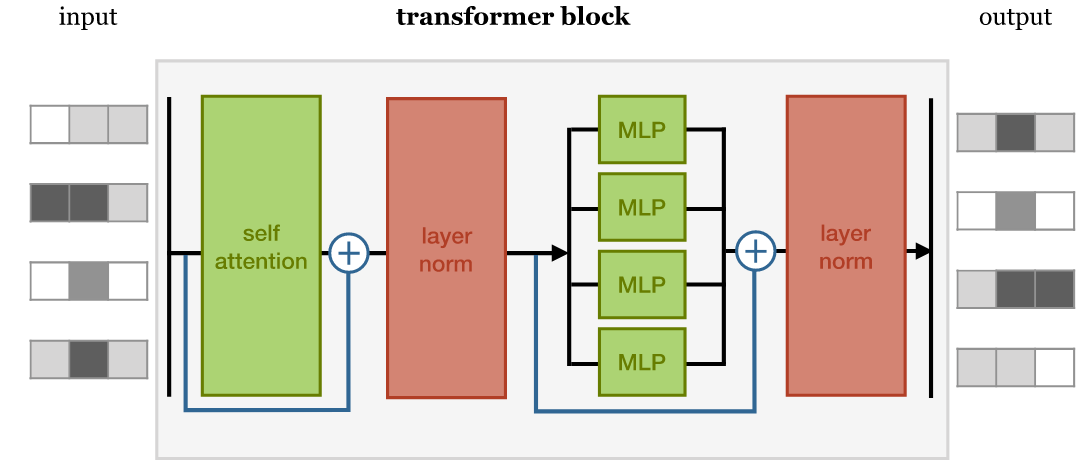

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0):
        super().__init__()
        self.attention = SelfAttention(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        ## Feed forward Network is given below : 
        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )
        self.do = nn.Dropout(dropout)

        ## For Layer Norm use nn.LayerNorm()
        ## For Drouput use nn.Dropout()
        ## Apply dropout after every layernorm (can you explain why this is done ??)
        
        ## Write your code here

    def forward(self, x):

        ## Write your code here
        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

## Inferences and Conclusion : State all the key observations and conclusion

#**Problem 2** : Sentiment Analysis using Transformers



1. Consider IMDB sentiment classification dataset or any other sentiment classification datase (Twitter, Amazon food review), consider only Positive and Negative classes.
2. Preprocess the data using text preprocessing texhniques
3. Perform the classification task using the transformer block built earlier (Construct a Classification transformer using the transformer block built above) (Below Image shows the Classification transformer)
4. Report Test accuracy and confusion matrix


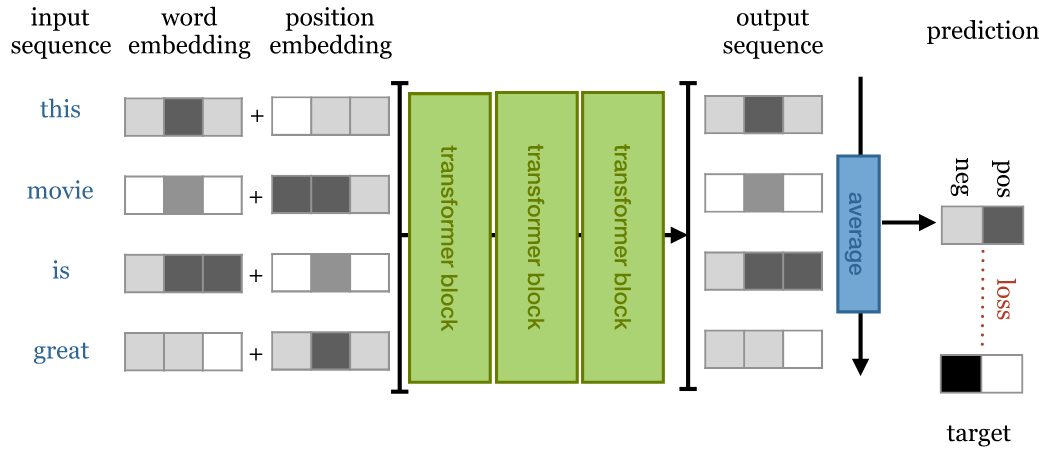

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

**Use the following configurations as default, you can vary these and observe the performance** : 

1. Number of Attention Heads : 8
2. Number of Transformer Blocks : 6
3. Embedding Size : 128
4. Max Sequence Length : 512

**Classification Transformer Block**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        ## Write your code here
        self.num_tokens, self.max_pool = num_tokens, max_pool

        ## For token and positional embeddings use nn.Embedding() 
        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        self.unify_embeddings = nn.Linear(2 * emb, emb)
        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """

        ## Write your code here
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2 * e)).view(b, t, e)
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)        

        return F.log_softmax(x, dim=1)




In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchtext.legacy import data, datasets, vocab

import numpy as np
import matplotlib.pyplot as plt


from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter

import random, tqdm, sys, math, gzip

# Used for converting between nats and bits
LOG2E = math.log2(math.e)
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)
NUM_CLS = 2

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)
examples = train.examples
print(examples[0].text)
print(examples[0].label)

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:02<00:00, 30.4MB/s]


['small', 'spoilers', 'alert', '!!!<br', '/><br', '/>good', 'movie...very', 'good', 'movie.', 'and', "i'm", 'surprised', 'to', 'say', 'that', 'myself,', 'because', "i'm", 'not', 'a', 'big', 'fan', 'of', 'vampires', 'and', 'the', 'sound', 'of', 'the', "director's", 'name', 'deran', 'serafian', 'usually', 'means', 'bad', 'news.', 'most', 'of', 'his', 'films', 'are', 'below', 'average', 'action', 'movies', 'like', 'death', 'warrant', 'and', 'gunmen.', 'this', 'was', 'one', 'of', 'his', 'first', 'films', 'and', 'maybe', 'he', 'should', 'have', 'continued', 'making', 'horror', 'movies', 'instead', 'of', 'action.', 'this', 'movie', 'really', 'fascinated', 'me.', 'good', 'accomplishment,', 'seeing', 'no', 'famous', 'actors', 'or', 'big', 'budget', 'was', 'involved.', 'it', 'really', 'is', 'the', 'story', 'that', 'keeps', 'you', 'focused.', 'especially', 'fans', 'of', 'the', 'original', 'dracula', 'myth', 'will', 'be', 'satisfied.', 'sarafian', 'lights', 'up', 'another', 'aspect', 'of', 'the',

In [ ]:
import torch, os

def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval

def d(tensor=None):
    """
    Returns a device string either for the best available device,
    or for the device corresponding to the argument
    :param tensor:
    :return:
    """
    if tensor is None:
        return 'cuda' if torch.cuda.is_available() else 'cpu'
    return 'cuda' if tensor.is_cuda else 'cpu'

def here(subpath=None):
    """
    :return: the path in which the package resides (the directory containing the 'former' dir)
    """
    if subpath is None:
        return os.path.abspath(os.path.join(os.path.dirname(__file__), '../..'))

    return os.path.abspath(os.path.join(os.path.dirname(__file__), '../..', subpath))

def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)

In [ ]:
def go(arg):
    """
    Creates and trains a basic transformer for the IMDB sentiment classification task.
    """
    tbw = SummaryWriter(log_dir=arg.tb_dir) # Tensorboard logging

    # load the IMDB data
    if arg.final:
        train, test = datasets.IMDB.splits(TEXT, LABEL)

        TEXT.build_vocab(train, max_size=arg.vocab_size - 2)
        LABEL.build_vocab(train)

        train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=arg.batch_size, device=d())
    else:
        tdata, _ = datasets.IMDB.splits(TEXT, LABEL)
        train, test = tdata.split(split_ratio=0.8)

        TEXT.build_vocab(train, max_size=arg.vocab_size - 2) # - 2 to make space for <unk> and <pad>
        LABEL.build_vocab(train)

        train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=arg.batch_size, device=d())

    print(f'- nr. of training examples {len(train_iter)}')
    print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.max_length < 0:
        mx = max([input.text[0].size(1) for input in train_iter])
        mx = mx * 2
        print(f'- maximum sequence length: {mx}')
    else:
        mx = arg.max_length

    # create the model
    model = CTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, seq_length=mx, num_tokens=arg.vocab_size, num_classes=NUM_CLS, max_pool=arg.max_pool)
    if torch.cuda.is_available():
        model.cuda()

    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())
    sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (arg.lr_warmup / arg.batch_size), 1.0))

    # training loop
    seen = 0
    for e in range(arg.num_epochs):

        print(f'\n epoch {e}')
        model.train(True)

        for batch in tqdm.tqdm(train_iter):

            opt.zero_grad()

            input = batch.text[0]
            label = batch.label - 1

            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input)
            loss = F.nll_loss(out, label)

            loss.backward()

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)

            opt.step()
            sch.step()

            seen += input.size(0)
            tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

        with torch.no_grad():

            model.train(False)
            tot, cor= 0.0, 0.0
            pred =[]
            true =[]

            for batch in test_iter:

                input = batch.text[0]
                label = batch.label - 1
                true.append(label)

                if input.size(1) > mx:
                    input = input[:, :mx]
                out = model(input).argmax(dim=1)
                pred.append(out)

                tot += float(input.size(0))
                cor += float((label == out).sum().item())

            acc = cor / tot
            print(f'-- {"test" if arg.final else "validation"} accuracy {acc:.3}')
            tbw.add_scalar('classification/test-loss', float(loss.item()), e)

    pred_ = []
    for x in pred:
      p = np.array(x.cpu())
      pred_.append(p)

    pred_ = np.concatenate(pred_)

    true_ = []
    for x in true:
      p = np.array(x.cpu())
      true_.append(p)

    true_ = np.concatenate(true_)

    print(classification_report(pred_, true_))
    cm = confusion_matrix(true_, pred_)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()


OPTIONS  Namespace(batch_size=16, depth=1, embedding_size=128, final=True, gradient_clipping=1.0, lr=0.001, lr_warmup=10000, max_length=512, max_pool=False, num_epochs=5, num_heads=8, seed=1, tb_dir='./runs', vocab_size=50000)
- nr. of training examples 1563
- nr. of test examples 1563

 epoch 0


100%|██████████| 1563/1563 [02:17<00:00, 11.34it/s]


-- test accuracy 0.833

 epoch 1


100%|██████████| 1563/1563 [02:17<00:00, 11.37it/s]


-- test accuracy 0.864

 epoch 2


100%|██████████| 1563/1563 [02:20<00:00, 11.10it/s]


-- test accuracy 0.852

 epoch 3


100%|██████████| 1563/1563 [02:19<00:00, 11.24it/s]


-- test accuracy 0.864

 epoch 4


100%|██████████| 1563/1563 [02:16<00:00, 11.48it/s]


-- test accuracy 0.839
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     10664
           1       0.91      0.80      0.85     14336

    accuracy                           0.84     25000
   macro avg       0.84      0.85      0.84     25000
weighted avg       0.85      0.84      0.84     25000



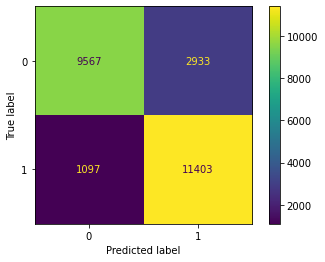

In [ ]:
import sys
sys.argv=['']
del sys
if __name__ == "__main__":

    parser = ArgumentParser()

    parser.add_argument("-e", "--num-epochs",
                        dest="num_epochs",
                        help="Number of epochs.",
                        default=5, type=int)

    parser.add_argument("-b", "--batch-size",
                        dest="batch_size",
                        help="The batch size.",
                        default=16, type=int)

    parser.add_argument("-l", "--learn-rate",
                        dest="lr",
                        help="Learning rate",
                        default=0.001, type=float)

    parser.add_argument("-T", "--tb_dir", dest="tb_dir",
                        help="Tensorboard logging directory",
                        default='./runs')

    parser.add_argument("-f", "--final", dest="final",
                        help="Whether to run on the real test set (if not included, the validation set is used).",
                        action="store_true")

    parser.add_argument("--max-pool", dest="max_pool",
                        help="Use max pooling in the final classification layer.",
                        action="store_true")

    parser.add_argument("-E", "--embedding", dest="embedding_size",
                        help="Size of the character embeddings.",
                        default=128, type=int)

    parser.add_argument("-V", "--vocab-size", dest="vocab_size",
                        help="Number of words in the vocabulary.",
                        default=50_000, type=int)

    parser.add_argument("-M", "--max", dest="max_length",
                        help="Max sequence length. Longer sequences are clipped (-1 for no limit).",
                        default=512, type=int)

    parser.add_argument("-H", "--heads", dest="num_heads",
                        help="Number of attention heads.",
                        default=8, type=int)

    parser.add_argument("-d", "--depth", dest="depth",
                        help="Depth of the network (nr. of self-attention layers)",
                        default=6, type=int)

    parser.add_argument("-r", "--random-seed",
                        dest="seed",
                        help="RNG seed. Negative for random",
                        default=1, type=int)

    parser.add_argument("--lr-warmup",
                        dest="lr_warmup",
                        help="Learning rate warmup.",
                        default=10_000, type=int)

    parser.add_argument("--gradient-clipping",
                        dest="gradient_clipping",
                        help="Gradient clipping.",
                        default=1.0, type=float)

    options = parser.parse_args()
    options.max_pool = False
    options.final = True
    options.depth = 1
    print('OPTIONS ', options)

    go(options)

OPTIONS  Namespace(batch_size=16, depth=1, embedding_size=64, final=True, gradient_clipping=1.0, lr=0.001, lr_warmup=10000, max_length=256, max_pool=False, num_epochs=5, num_heads=6, seed=1, tb_dir='./runs', vocab_size=50000)
- nr. of training examples 1563
- nr. of test examples 1563

 epoch 0


100%|██████████| 1563/1563 [00:37<00:00, 41.23it/s]


-- test accuracy 0.79

 epoch 1


100%|██████████| 1563/1563 [00:37<00:00, 42.00it/s]


-- test accuracy 0.848

 epoch 2


100%|██████████| 1563/1563 [00:37<00:00, 41.94it/s]


-- test accuracy 0.843

 epoch 3


100%|██████████| 1563/1563 [00:37<00:00, 41.78it/s]


-- test accuracy 0.843

 epoch 4


100%|██████████| 1563/1563 [00:37<00:00, 41.89it/s]


-- test accuracy 0.841
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     12570
           1       0.84      0.84      0.84     12430

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



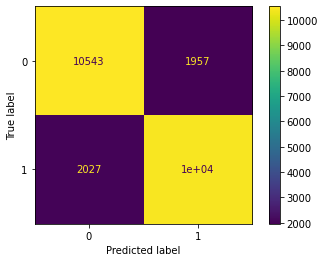

In [ ]:
options = parser.parse_args()
options.max_pool = False
options.final = True
options.depth = 1
options.embedding_size = 64
options.max_length = 256
options.num_heads = 6 
print('OPTIONS ', options)

go(options)

## Inferences and Conclusion : State all the key observations and conclusion

### Results with default setting 

Accuracy after 5 epochs

*  validation = 0.5
*  Test = 0.5

### Results with following setting


1. Number of Attention Heads : 10
2. Number of Transformer Blocks : 8
3. Embedding Size : 64
4. Max Sequence Length : 256



Accuracy after 5 epochs

*  validation = 0.5
*  Test = 0.5

### Results with following setting


1. Number of Attention Heads : 8
2. Number of Transformer Blocks : 2
3. Embedding Size : 128
4. Max Sequence Length : 512



Accuracy after 5 epochs

*  validation = 0.72
*  Test = 0.78

### Results with following setting


1. Number of Attention Heads : 8
2. Number of Transformer Blocks : 1
3. Embedding Size : 128
4. Max Sequence Length : 512



Accuracy after 5 epochs

*  validation = 0.8
*  Test = 0.84

